<a href="https://colab.research.google.com/github/AbdoulayeDiop/ner-with-bert/blob/main/ner_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers[torch] datasets evaluate seqeval

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
from datasets import load_dataset

dataset = load_dataset("eriktks/conll2003", trust_remote_code=True)
dataset['train'] = dataset['train'].shuffle(seed=42).select(range(1000))
dataset['test'] = dataset['test'].shuffle(seed=42).select(range(1000))

C:\Users\abdou\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [5]:
dataset["train"][0]

{'id': '1469',
 'tokens': ['"',
  'Neither',
  'the',
  'National',
  'Socialists',
  '(',
  'Nazis',
  ')',
  'nor',
  'the',
  'communists',
  'dared',
  'to',
  'kidnap',
  'an',
  'American',
  'citizen',
  ',',
  '"',
  'he',
  'shouted',
  ',',
  'in',
  'an',
  'oblique',
  'reference',
  'to',
  'his',
  'extradition',
  'to',
  'Germany',
  'from',
  'Denmark',
  '.',
  '"'],
 'pos_tags': [0,
  12,
  12,
  22,
  23,
  4,
  23,
  5,
  10,
  12,
  24,
  38,
  35,
  37,
  12,
  16,
  21,
  6,
  0,
  28,
  38,
  6,
  15,
  12,
  16,
  21,
  35,
  29,
  21,
  35,
  22,
  15,
  22,
  7,
  0],
 'chunk_tags': [0,
  11,
  11,
  12,
  12,
  0,
  11,
  0,
  0,
  11,
  12,
  21,
  22,
  22,
  11,
  12,
  12,
  0,
  0,
  11,
  21,
  0,
  13,
  11,
  12,
  12,
  13,
  11,
  12,
  13,
  11,
  13,
  11,
  12,
  0],
 'ner_tags': [0,
  0,
  0,
  7,
  8,
  0,
  7,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  0,
  5,
  0

In [6]:
label_list = dataset["train"].features[f"ner_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [8]:
example = dataset["train"][0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]',
 '"',
 'neither',
 'the',
 'national',
 'socialists',
 '(',
 'nazis',
 ')',
 'nor',
 'the',
 'communists',
 'dared',
 'to',
 'kidnap',
 'an',
 'american',
 'citizen',
 ',',
 '"',
 'he',
 'shouted',
 ',',
 'in',
 'an',
 'oblique',
 'reference',
 'to',
 'his',
 'extra',
 '##dition',
 'to',
 'germany',
 'from',
 'denmark',
 '.',
 '"',
 '[SEP]']

In [9]:
tokenized_input.word_ids()

[None,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 None]

In [10]:
def tokenize_and_preserve_labels(sentence):
    tokenized_sentence = tokenizer(sentence["tokens"], is_split_into_words=True)
    labels = []
    for word_idx in tokenized_sentence.word_ids():
        label = tokenized_input.word_ids
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(sentence["ner_tags"][word_idx])
    tokenized_sentence["labels"] = labels
    return tokenized_sentence

In [11]:
sentence = dataset["train"][0]
tokenized_sentence = tokenize_and_preserve_labels(sentence)
print(tokenized_sentence)
# print([dataset["train"].features[f"ner_tags"].feature.names[label] for label in tokenized_sentence.labels if label >= 0])

{'input_ids': [101, 1000, 4445, 1996, 2120, 21633, 1006, 13157, 1007, 4496, 1996, 13009, 15048, 2000, 22590, 2019, 2137, 6926, 1010, 1000, 2002, 6626, 1010, 1999, 2019, 20658, 4431, 2000, 2010, 4469, 20562, 2000, 2762, 2013, 5842, 1012, 1000, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, 0, 0, 7, 8, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, -100]}


In [12]:
tokenized_dataset = dataset.map(tokenize_and_preserve_labels)

In [13]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [14]:
import evaluate
seqeval = evaluate.load("seqeval")

In [15]:
import numpy as np

labels = [label_list[i] for i in example[f"ner_tags"]]
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [16]:
id2label = dict(zip(range(len(label_list)), label_list))
label2id = {v: k for k, v in id2label.items()}

In [17]:
import torch
from transformers import BertTokenizer, BertForTokenClassification, TrainingArguments, Trainer
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(label_list), id2label=id2label, label2id=label2id)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
training_args = TrainingArguments(
    output_dir="ner-with-bert",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=20,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/630 [00:00<?, ?it/s]C:\Users\abdou\AppData\Roaming\Python\Python310\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
                                                
 10%|█         | 63/630 [00:41<02:33,  3.69it/s] 

{'eval_loss': 0.3469000458717346, 'eval_precision': 0.5127778932059007, 'eval_recall': 0.5858058390695466, 'eval_f1': 0.5468646133392421, 'eval_accuracy': 0.9093639941992956, 'eval_runtime': 18.5852, 'eval_samples_per_second': 185.793, 'eval_steps_per_second': 11.622, 'epoch': 1.0}


                                                  
 20%|██        | 126/630 [01:22<02:28,  3.39it/s]

{'eval_loss': 0.21194975078105927, 'eval_precision': 0.6790068720904455, 'eval_recall': 0.7270353667220508, 'eval_f1': 0.7022008253094911, 'eval_accuracy': 0.9446343484565983, 'eval_runtime': 18.8913, 'eval_samples_per_second': 182.782, 'eval_steps_per_second': 11.434, 'epoch': 2.0}


                                                 
 30%|███       | 189/630 [02:04<01:59,  3.68it/s]

{'eval_loss': 0.17624258995056152, 'eval_precision': 0.7466545701973236, 'eval_recall': 0.7813909328269641, 'eval_f1': 0.7636279285548597, 'eval_accuracy': 0.9552344451350044, 'eval_runtime': 19.0323, 'eval_samples_per_second': 181.428, 'eval_steps_per_second': 11.349, 'epoch': 3.0}


                                                 
 40%|████      | 252/630 [02:46<01:56,  3.26it/s]

{'eval_loss': 0.15533994138240814, 'eval_precision': 0.7787205537568382, 'eval_recall': 0.8277949204842155, 'eval_f1': 0.8025081976643847, 'eval_accuracy': 0.9610006215040398, 'eval_runtime': 19.3085, 'eval_samples_per_second': 178.833, 'eval_steps_per_second': 11.187, 'epoch': 4.0}


                                                 
 50%|█████     | 315/630 [03:27<01:34,  3.35it/s]

{'eval_loss': 0.15633469820022583, 'eval_precision': 0.8264808362369338, 'eval_recall': 0.8445288393069071, 'eval_f1': 0.8354073726226813, 'eval_accuracy': 0.96512671776811, 'eval_runtime': 19.2221, 'eval_samples_per_second': 179.637, 'eval_steps_per_second': 11.237, 'epoch': 5.0}


                                                 
 60%|██████    | 378/630 [04:10<01:07,  3.74it/s]

{'eval_loss': 0.15879936516284943, 'eval_precision': 0.8180683236863012, 'eval_recall': 0.8554474246380251, 'eval_f1': 0.8363404304693393, 'eval_accuracy': 0.9645915337338582, 'eval_runtime': 19.6833, 'eval_samples_per_second': 175.428, 'eval_steps_per_second': 10.974, 'epoch': 6.0}


                                                 
 70%|███████   | 441/630 [04:52<00:52,  3.57it/s]

{'eval_loss': 0.15861663222312927, 'eval_precision': 0.8319889375432127, 'eval_recall': 0.8568715879420841, 'eval_f1': 0.8442469597754911, 'eval_accuracy': 0.9663179338443477, 'eval_runtime': 19.4746, 'eval_samples_per_second': 177.308, 'eval_steps_per_second': 11.091, 'epoch': 7.0}


 79%|███████▉  | 500/630 [05:13<00:41,  3.13it/s]

{'loss': 0.1692, 'grad_norm': 0.27311256527900696, 'learning_rate': 4.126984126984127e-06, 'epoch': 7.94}


                                                 
 80%|████████  | 504/630 [05:34<00:36,  3.42it/s]

{'eval_loss': 0.16127502918243408, 'eval_precision': 0.8330262551819438, 'eval_recall': 0.8585331117968193, 'eval_f1': 0.8455873758036236, 'eval_accuracy': 0.9663524618465575, 'eval_runtime': 19.5751, 'eval_samples_per_second': 176.397, 'eval_steps_per_second': 11.034, 'epoch': 8.0}


                                                 
 90%|█████████ | 567/630 [06:16<00:18,  3.35it/s]

{'eval_loss': 0.16335426270961761, 'eval_precision': 0.833929189251528, 'eval_recall': 0.8581770709708046, 'eval_f1': 0.845879394045739, 'eval_accuracy': 0.966438781852082, 'eval_runtime': 19.6197, 'eval_samples_per_second': 175.997, 'eval_steps_per_second': 11.009, 'epoch': 9.0}


                                                 
100%|██████████| 630/630 [07:01<00:00,  3.28it/s]

{'eval_loss': 0.16393519937992096, 'eval_precision': 0.8352180936995154, 'eval_recall': 0.8590078328981723, 'eval_f1': 0.8469459396208753, 'eval_accuracy': 0.9666459498653408, 'eval_runtime': 20.2171, 'eval_samples_per_second': 170.796, 'eval_steps_per_second': 10.684, 'epoch': 10.0}


100%|██████████| 630/630 [07:04<00:00,  1.48it/s]

{'train_runtime': 424.3862, 'train_samples_per_second': 23.563, 'train_steps_per_second': 1.484, 'train_loss': 0.1378250489159236, 'epoch': 10.0}


TrainOutput(global_step=630, training_loss=0.1378250489159236, metrics={'train_runtime': 424.3862, 'train_samples_per_second': 23.563, 'train_steps_per_second': 1.484, 'total_flos': 240608297837232.0, 'train_loss': 0.1378250489159236, 'epoch': 10.0})

In [25]:
tokenized_dataset["test"] = tokenized_dataset["test"].shuffle().select(range(1000))

In [33]:
from seqeval.metrics import classification_report
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
print(classification_report(true_labels, true_predictions))

100%|██████████| 63/63 [00:06<00:00, 10.12it/s]

              precision    recall  f1-score   support

         LOC       0.77      0.82      0.79       570
        MISC       0.58      0.66      0.62       314
         ORG       0.74      0.83      0.78       725
         PER       0.91      0.94      0.93       766

   micro avg       0.78      0.84      0.81      2375
   macro avg       0.75      0.81      0.78      2375
weighted avg       0.78      0.84      0.81      2375



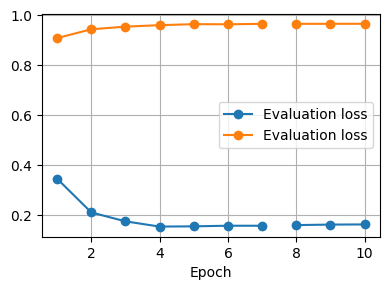

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(trainer.state.log_history)
plt.figure(figsize=(4, 3))
plt.plot(df["epoch"], df["eval_loss"], marker="o", label="Evaluation loss")
plt.plot(df["epoch"], df["eval_accuracy"], marker="o", label="Evaluation loss")
# df.plot("epoch", ["eval_loss", "eval_accuracy"], marker="o")
plt.xlabel("Epoch")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
n_examples = [10, 30, 100, 300, 1000]
learning_curves = {
    n: {
        "precision": [],
        "recall": [],
        "f1": [],
        "accuracy": [],
    } for n in n_examples
}
for n in n_examples:
    for _ in range(10):
        model = BertForTokenClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=len(label_list),
            id2label=id2label,
            label2id=label2id
        )
        
        training_args = TrainingArguments(
            output_dir="ner-with-bert",
            overwrite_output_dir=True,
            learning_rate=2e-5,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            num_train_epochs=20,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            # push_to_hub=True,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_dataset["train"].shuffle().select(range(n)),
            eval_dataset=tokenized_dataset["test"],
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )

        trainer.train()
        df = pd.DataFrame(trainer.state.log_history)
        plt.figure(figsize=(4, 3))
        plt.plot(df["epoch"], df["eval_loss"], marker="o", label="Evaluation loss")
        plt.plot(df["epoch"], df["eval_accuracy"], marker="o", label="Evaluation loss")
        # df.plot("epoch", ["eval_loss", "eval_accuracy"], marker="o")
        plt.xlabel("Epoch")
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

        eval_scores = trainer.evaluate()
        for metric in eval_scores:
            learning_curves[n][metric].append(eval_scores[metric])

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


































                                         
                                                 
  2%|▏         | 5/320 [05:53<1:13:11, 13.94s/it]


{'eval_loss': 1.9227641820907593, 'eval_precision': 0.030352748154224774, 'eval_recall': 0.07789473684210527, 'eval_f1': 0.043683589138134596, 'eval_accuracy': 0.5038475411807142, 'eval_runtime': 81.1544, 'eval_samples_per_second': 12.322, 'eval_steps_per_second': 0.394, 'epoch': 1.0}
